In [1]:

import pandas as pd

# %% [markdown]
# # Code voor het filtreren van de data

# %% [markdown]
# ### Sorteren van CSV file in een lijst

# %%
delta_time = []

with open('hoek_0_c1.csv', 'r', newline='') as file:
    next(file)
    for line in file:
        line_splitted = line.split(',')
        delta_time.append(float(line_splitted[4]))
    delta_time.pop(0)
print(delta_time)

# %% [markdown]
# ### Filtreren van de lijst
# Op basis van:
# - Groter dan nul
# - Een bovengrens

# %%
sorted_delta_time = []

for i in delta_time:
    if i > 0 and i < 7.5 :
        sorted_delta_time.append(i)

print(sorted_delta_time)

# Lengte van de lijst
print(len(sorted_delta_time))

# %% [markdown]
# ### Berekenen van de muon-flux

# %%
#Aantal detecties
N = len(sorted_delta_time)
#Lengte meting (in s)
t = 5460
#Oppervlakte (m^2)
A = 0.030551
#Solid Angle
O = 1

flux = N/(t*A*O)
print(flux)

# %% [markdown]
# ### Percentage van de data onder een grens 'n'

# %%
# Definieer een bovengrens 'n'
n = 7.5
count = 0

for i in delta_time:
    if i < n:
        count += 1

print(count/(len(delta_time)))

# %% [markdown]
# ### Gemiddelde $\Delta$ time na filtreren

# %%
count = 0

for i in sorted_delta_time:
    if i < 7.5:
        count += i

print(count/(len(sorted_delta_time)))

# %% [markdown]
#



ModuleNotFoundError: No module named 'pandas'

In [3]:
import re, math, pathlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ----------------------------- instellingen -----------------------------
FILES = [
    "hoek_0_c1.csv",  "hoek_0_c2.csv",
    "hoek_20_E_c1.csv","hoek_20_E_c2.csv","hoek_20_W_c1.csv","hoek_20_W_c2.csv",
    "hoek_40_E_c1.csv","hoek_40_E_c2.csv","hoek_40_W_c1.csv","hoek_40_W_c2.csv",
    "hoek_60_E_c1.csv","hoek_60_E_c2.csv","hoek_60_W_c1.csv","hoek_60_W_c2.csv",
]
T   = 5460
A   = 0.030551
ANG = [0, 20, 40, 60]

flux_E = {theta: [] for theta in ANG}
flux_W = {theta: [] for theta in ANG}

pat = re.compile(r"hoek_(\d+)(?:_([EW]))?_c\d\.csv")

for f in FILES:
    m = pat.fullmatch(pathlib.Path(f).name)
    if not (m and pathlib.Path(f).exists()):
        continue
    theta   = int(m.group(1))
    dir_ = m.group(2) or "E"

    N = pd.read_csv(f, nrows=1)["Total coincidences"].iloc[0]
    flux = N / (T * A)

    (flux_E if dir_ == "E" else flux_W)[theta].append(flux)
    if theta == 0:
        flux_W[theta].append(flux)

print("\nStatistieken per hoek (flux in s⁻¹ m⁻² sr⁻¹)")
print(f"{'theta':>3} {'Dir':>4} {'Runs':>4} {'Gem.':>10} {'σ':>10} {'Min':>10} {'Max':>10}")
for theta in ANG:
    for label, dct in [('E', flux_E), ('W', flux_W)]:
        vals = np.array(dct[theta])
        if vals.size:
            mean = vals.mean()
            sigma = vals.std(ddof=1) if vals.size > 1 else 0
            print(f"{theta:>3} {label:>4} {vals.size:>4} {mean:>10.2f} {sigma:>10.2f} "
                  f"{vals.min():>10.2f} {vals.max():>10.2f}")
        else:
            print(f"{theta:>3} {label:>4} {0:>4} {'-':>10} {'-':>10} {'-':>10} {'-':>10}")

angles = np.array(ANG)
mean_E = [np.mean(flux_E[theta]) if flux_E[theta] else math.nan for theta in ANG]
mean_W = [np.mean(flux_W[theta]) if flux_W[theta] else math.nan for theta in ANG]

plt.plot(angles, mean_E, "o-", label="East")
plt.plot(angles, mean_W, "o-", label="West")
plt.xlabel("Hoek (°)")
plt.ylabel("Flux (s⁻¹ m⁻² sr⁻¹)")
plt.title("Muon-flux per hoek (ruwe totals)")
plt.grid(True); plt.legend(); plt.tight_layout(); plt.show()


ImportError: Error importing numpy: you should not try to import numpy from
        its source directory; please exit the numpy source tree, and relaunch
        your python interpreter from there.


=== Samenvatting per hoek & richting ===
 Angle (°) Direction  N total  t total (s)  Gem. flux  Poisson sigma  Min flux  Max flux
         0      East     5032      23264.6      7.080          0.100     6.639     7.323
        20      East     2421      16919.5      4.684          0.095     4.258     5.127
        40      East    11164     170538.2      2.143          0.020     2.110     2.174
        60      East    11694     638425.8      0.600          0.006     0.579     0.620
         0      West     5032      23264.6      7.080          0.100     6.639     7.323
        20      West    27234     153388.2      5.812          0.035     5.447     6.145
        40      West     2428      32794.9      2.423          0.049     2.349     2.499
        60      West     3443     176409.5      0.639          0.011     0.578     0.700


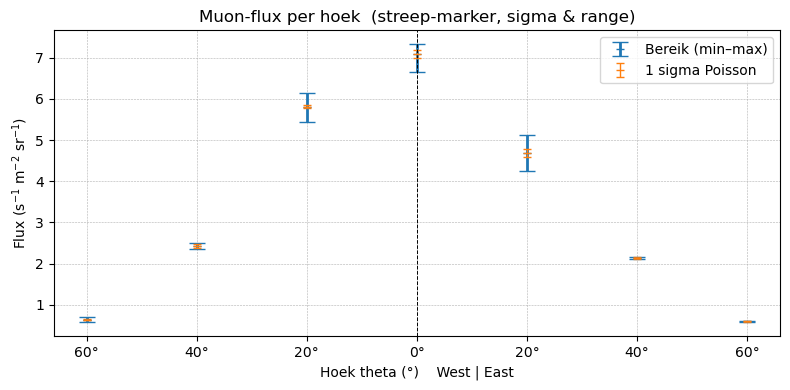

In [28]:
#!/usr/bin/env python3
import re, math, pathlib
from collections import defaultdict

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

CSV_FILES = [
    "hoek_0_c1.csv",  "hoek_0_c2.csv",
    "hoek_20_E_c1.csv","hoek_20_E_c2.csv","hoek_20_W_c1.csv","hoek_20_W_c2.csv",
    "hoek_40_E_c1.csv","hoek_40_E_c2.csv","hoek_40_W_c1.csv","hoek_40_W_c2.csv",
    "hoek_60_E_c1.csv","hoek_60_E_c2.csv","hoek_60_W_c1.csv","hoek_60_W_c2.csv",
]
SURFACE = 0.030551
FILENAME_PATTERN = re.compile(r"hoek_(\d+)(?:_([EW]))?_c\d+\.csv")

tot_N, tot_t, runs = defaultdict(int), defaultdict(float), defaultdict(list)

for fn in CSV_FILES:
    path = pathlib.Path(fn)
    m = FILENAME_PATTERN.fullmatch(path.name)
    if not (m and path.exists()):
        print("⨯", fn, "overgeslagen")
        continue

    theta   = int(m.group(1))
    dir_= m.group(2) or "E"
    key = (theta, dir_)
    hdr = pd.read_csv(path, nrows=1)
    N   = int(hdr["Total coincidences"][0])
    t   = float(hdr["Total runtime (s)"][0])
    flux_run = N / (t * SURFACE)

    tot_N[key] += N
    tot_t[key] += t
    runs[key].append(flux_run)

    if theta == 0 and dir_ == "E":
        key_W = (0, "W")
        tot_N[key_W] += N
        tot_t[key_W] += t
        runs[key_W].append(flux_run)


##
## Work in Progress
##
def solid_angle(theta_deg, A=0.030551, d=0.30):
    theta = np.radians(theta_deg)
    return A * np.cos(theta) / d**2

def get_flux(N, t):  return N / (t * SURFACE) if t else math.nan
def get_sigma(N, t): return math.sqrt(N) / (t * SURFACE) if t else math.nan

records = []
for (theta, dir_), N in tot_N.items():
    t  = tot_t[(theta, dir_)]
    f  = get_flux(N, t)
    sigma  = get_sigma(N, t)
    rec = {
        "Angle (°)": theta,
        "Direction": "East" if dir_ == "E" else "West",
        "N total": N,
        "t total (s)": round(t, 1),
        "Gem. flux": round(f, 3),
        "Poisson sigma": round(sigma, 3),
        "Min flux": round(min(runs[(theta, dir_)]), 3),
        "Max flux": round(max(runs[(theta, dir_)]), 3),
    }
    records.append(rec)

df = pd.DataFrame(records).sort_values(["Direction", "Angle (°)"])
print("\n=== Samenvatting per hoek & richting ===")
print(df.to_string(index=False))

signed_angles = sorted({a if d=="E" else -a for (a,d) in tot_N})
mean_flux     = [get_flux(tot_N[(abs(a),"E" if a>=0 else "W")],
                      tot_t[(abs(a),"E" if a>=0 else "W")]) for a in signed_angles]
sig_flux      = [get_sigma(tot_N[(abs(a),"E" if a>=0 else "W")],
                       tot_t[(abs(a),"E" if a>=0 else "W")]) for a in signed_angles]
rng_lo        = [mean_flux[i] - min(runs[(abs(a),"E" if a>=0 else "W")])
                 for i,a in enumerate(signed_angles)]
rng_hi        = [max(runs[(abs(a),"E" if a>=0 else "W")]) - mean_flux[i]
                 for i,a in enumerate(signed_angles)]
xtick_labels  = [f"{abs(a)}°" for a in signed_angles]

plt.figure(figsize=(8,4))
plt.errorbar(signed_angles, mean_flux,
             yerr=[rng_lo, rng_hi], fmt="_", lw=0,
             elinewidth=2, capsize=6, label="Bereik (min–max)")
plt.errorbar(signed_angles, mean_flux,
             yerr=sig_flux, fmt="_", lw=0,
             elinewidth=1, capsize=3, label="1 sigma Poisson")

plt.axvline(0, color="k", ls="--", lw=0.7)
plt.xticks(signed_angles, xtick_labels)
plt.xlabel("Hoek theta (°)    West | East")
plt.ylabel("Flux (s$^{-1}$ m$^{-2}$ sr$^{-1}$)")
plt.title("Muon-flux per hoek  (streep-marker, sigma & range)")
plt.grid(True, ls="--", lw=0.4)
plt.legend(loc="upper right")
plt.tight_layout()
plt.show()


Projectie Wet: $$A_\text{proj} = A\cos\theta$$

$$Φ(\theta)=I_0 \cos\theta$$

Side  Exponent n      ±1σ     χ²/ndf  Shared I0
West    3.515907 0.023066  33.108421   7.079768
East    3.739849 0.013385 395.139469   7.079768


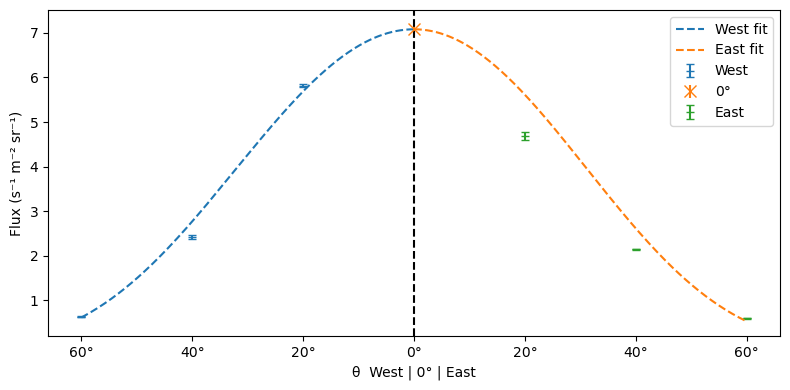

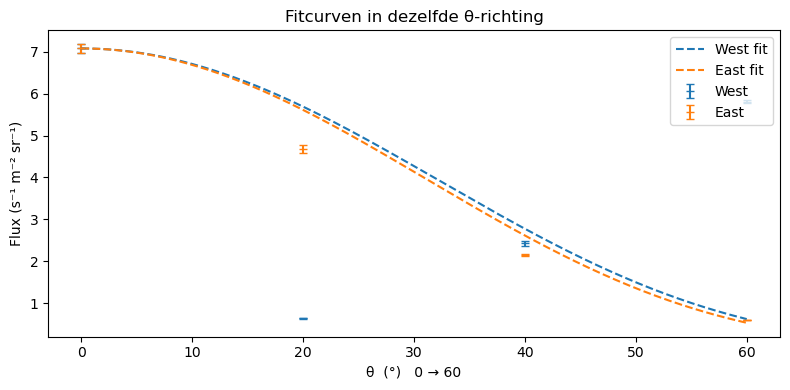

In [25]:
# %% Geometrische fits (West & East) — verticale flux gedeeld + tabel
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# ---------- data uit vorige cellen ----------
angles_raw = np.array(signed_angles, float)
flux_raw   = np.array(mean_flux,    float)
sigma_raw  = np.array(sig_flux,     float)

# ---------- unieke punten (dubbel 0° voorkomen) ----------
unique = {θ: (Φ, σ) for θ, Φ, σ in zip(angles_raw, flux_raw, sigma_raw)}
angles = np.array(sorted(unique), float)
flux   = np.array([unique[θ][0] for θ in angles])
sigma  = np.array([unique[θ][1] for θ in angles])

mask_vert = angles == 0
mask_east = angles >  0
mask_west = angles <  0

angle_vert   = angles[mask_vert][0]
flux_vert    = flux[mask_vert][0]
sigma_vert   = sigma[mask_vert][0]

angles_east  =  angles[mask_east]
flux_east    =  flux[mask_east]
sigma_east   =  sigma[mask_east]

angles_west  = -angles[mask_west]
flux_west    =  flux[mask_west]
sigma_west   =  sigma[mask_west]

# ---------- model met vast I0 ----------
def model(theta_deg, exponent):
    return flux_vert * np.cos(np.radians(theta_deg)) ** exponent

def fit_exponent(theta_deg, flux_vals, sigma_vals):
    popt, pcov = curve_fit(
        model,
        theta_deg,
        flux_vals,
        sigma=sigma_vals,
        absolute_sigma=True,
        p0=[2]
    )
    exponent     = popt[0]
    exponent_err = np.sqrt(pcov[0, 0])
    residuals    = (flux_vals - model(theta_deg, exponent)) / sigma_vals
    chi2         = np.sum(residuals**2)
    ndf          = len(theta_deg) - 1
    return exponent, exponent_err, chi2 / ndf

n_east, err_east, chi2_east = fit_exponent(angles_east, flux_east, sigma_east)
n_west, err_west, chi2_west = fit_exponent(angles_west, flux_west, sigma_west)

# ---------- tabel met resultaten ----------
table = pd.DataFrame({
    "Side":   ["West", "East"],
    "Exponent n":   [n_west, n_east],
    "±1σ":          [err_west, err_east],
    "χ²/ndf":       [chi2_west, chi2_east],
    "Shared I0":    [flux_vert, flux_vert]
})
print(table.to_string(index=False))

# ---------- fitcurves ----------
theta_fit = np.linspace(0, max(angles_east.max(), angles_west.max()), 300)
fit_curve_east = model(theta_fit, n_east)
fit_curve_west = model(theta_fit, n_west)

# ---------- grafiek 1: West links, East rechts ----------
plt.figure(figsize=(8, 4))
plt.errorbar(-angles_west, flux_west, yerr=sigma_west, fmt="_", capsize=3, label="West")
plt.errorbar(angle_vert, flux_vert, yerr=sigma_vert, fmt="x", ms=8, label="0°")
plt.errorbar( angles_east, flux_east, yerr=sigma_east, fmt="_", capsize=3, label="East")
plt.plot(-theta_fit, fit_curve_west, "C0--", label="West fit")
plt.plot( theta_fit, fit_curve_east, "C1--", label="East fit")
plt.axvline(0, color="k", ls="--")
xt = np.concatenate([-angles_west[::-1], [angle_vert], angles_east])
plt.xticks(xt, [f"{abs(v):.0f}°" for v in xt])
plt.xlabel("θ  West | 0° | East")
plt.ylabel("Flux (s⁻¹ m⁻² sr⁻¹)")
plt.legend(loc="upper right")
plt.tight_layout()
plt.show()

# ---------- grafiek 2: 0° links, beide kanten positief ----------
angles_plot = np.insert(angles_east, 0, 0)
flux_east_p  = np.insert(flux_east, 0, flux_vert)
sigma_east_p = np.insert(sigma_east, 0, sigma_vert)
flux_west_p  = np.insert(flux_west, 0, flux_vert)
sigma_west_p = np.insert(sigma_west, 0, sigma_vert)

plt.figure(figsize=(8, 4))
plt.errorbar(angles_plot, flux_west_p, yerr=sigma_west_p, fmt="_", capsize=3, label="West")
plt.errorbar(angles_plot, flux_east_p, yerr=sigma_east_p, fmt="_", capsize=3, label="East")
plt.plot(theta_fit, fit_curve_west, "C0--", label="West fit")
plt.plot(theta_fit, fit_curve_east, "C1--", label="East fit")
plt.xlabel("θ  (°)   0 → 60")
plt.ylabel("Flux (s⁻¹ m⁻² sr⁻¹)")
plt.title("Fitcurven in dezelfde θ-richting")
plt.legend(loc="upper right")
plt.tight_layout()
plt.show()
